### Update 4 - Jay's contributions

Will do the following:

**1. Indicator kriging** 

       a. Recompute and check the indicator variograms (indicator transformed facies)

       b. Indicator kriging on facies to calculate probability of each facies across reservoir
   
   
**2. Ordinary kriging for porosity and permeability**

       a. Plan to apply ordinary kriging because it does not assume a stationary mean in the data
       
       b. Will be removing the trend if a strong trend within the porosity or permeability in a facies is detected
       
       b. The variograms for each property within each facies will be recomputed and modeled
       
       c. Using the variogram models, the ordinary kriging will be performed

### Initial data pre-processing
Outlier removal and then basic well data visualization.

In [1]:
# Imports
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics

In [2]:
class Univariate():
    def __init__(self,welldata):
        self.filename = welldata # set filename
        self.welldata = pd.read_csv(welldata) # read well data into dataframe
        #self.sandstone = self.welldata.loc[(data.welldata['Facies'] == 1)] # Group by facies (Sandstone)
        #self.shale = self.welldata.loc[(data.welldata['Facies'] == 0)] # Group by facies (Shale)

        
    def comp_outliers(self,dataframe,metric):
        # computes the upper and lower fence based on Tukey 1.5 x IQR method and returns an array of format 
        # [lower_fence,upper_fence]
        P25 = np.percentile(dataframe[metric].values,25)
        P75 = np.percentile(dataframe[metric].values,75)
        lower_fence = P25 - 1.5*(P75-P25)
        upper_fence = P75 + 1.5*(P75-P25)
        if lower_fence < 0.0:
            lower_fence = 0.0
        return [lower_fence,upper_fence]
    
    def remove_outliers(self,dataframe,metric):
        # removes outliers from dataframe and returns new dataframe without outliers
        bounds = self.comp_outliers(dataframe,metric)
        cleaned_data = dataframe.loc[(dataframe[metric] >= bounds[0]) & (dataframe[metric] <= bounds[1])]
        return cleaned_data 

In [3]:
# load original csv file
data = Univariate('Data/1_sample_data.csv')
df_raw = pd.read_csv('Data/1_sample_data.csv')

In [4]:
# doing facies separation and outlier removal
# pulling out the raw facies data
Sandstone_raw = data.welldata.loc[(data.welldata['Facies'] == 1)]
Shale_raw = data.welldata.loc[(data.welldata['Facies'] == 0)]
# outlier removal for sandstone (porosity, permeability, acoustic impedance)
Sandstone_cleaned_por = data.remove_outliers(Sandstone_raw,'Porosity')
Sandstone_cleaned_por_perm = data.remove_outliers(Sandstone_cleaned_por,'Perm')
Sandstone_final = data.remove_outliers(Sandstone_cleaned_por_perm,'AI')
# outlier removal for shale (porosity, permeability, acoustic impedance)
Shale_cleaned_por = data.remove_outliers(Shale_raw,'Porosity')
Shale_cleaned_por_perm = data.remove_outliers(Shale_cleaned_por,'Perm')
Shale_final = data.remove_outliers(Shale_cleaned_por_perm,'AI')

In [5]:
# combining facies for total 'cleaned' dataset
df_clean = pd.concat([Sandstone_final,Shale_final])
del df_clean['Unnamed: 0']

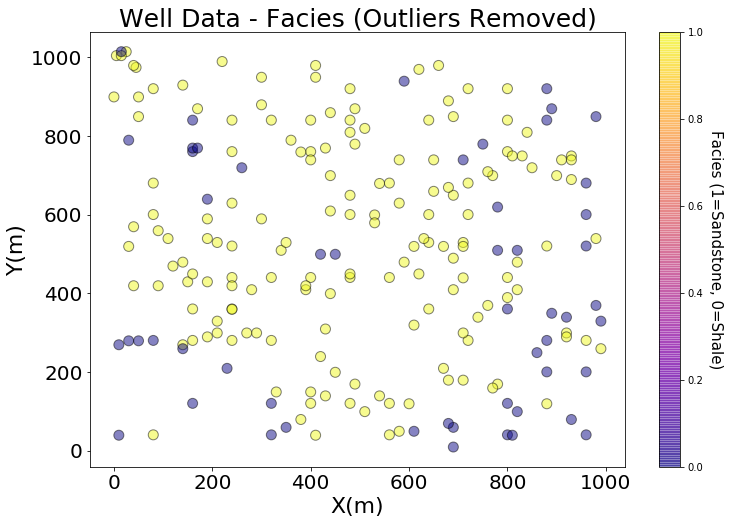

In [6]:
# visualize the facies locations
plt.figure(figsize=(12,8))
im = plt.scatter(df_clean['X'],df_clean['Y'],s=100,c=df_clean['Facies'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=0,
                 vmax=1,alpha=0.5,verts=None,edgecolors="black")
plt.title('Well Data - Facies (Outliers Removed)', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Facies (1=Sandstone, 0=Shale)',rotation=270,labelpad=20,size=15)
plt.show()

### 1. Indicator Kriging Workflow

First the indicator transform is applied. The indicator transformed values are then subjected to an NScore transform to force the variance, and subsequently the sill of the variogram to be 1.0.

In [7]:
# indicator transform
sand = np.zeros(len(df_clean))
shale = np.zeros(len(df_clean))
df_clean.reset_index(inplace=True)
for i in range(0,len(df_clean)):
    if df_clean['Facies'][i] == 0:
        shale[i] = 1
    else:
        sand[i] = 1
df_clean['indicator_sand'] = pd.Series(sand)
df_clean['indicator_shale'] = pd.Series(shale)

In [8]:
# normalizing the facies indicator distributions with nscore
df_clean['NSand'], tvSand, tnsSand = geostats.nscore(df_clean, 'indicator_sand')
df_clean['NShale'], tvShale, tnsShale = geostats.nscore(df_clean, 'indicator_shale')

From previous update the major/minor axis of the field were determined to be 22.5/112.5 degrees. It was noted that this major/minor axis was reversed for the facies, so the major axis is 112.5 degrees and the minor is 22.5 degrees for the continuity of facies in the field. These directions can be visually confirmed by looking at the well data facies plot above.

The directional variogram for the indicator transformed facies is shown below. The lag distance and lag tolerance are both 40m which does result in double-counting of data. But, by doing so a smoother variogram can be obtained while using a relatively short lag distance. The variogram is calculated out to a 700m distance, but we note that beyond 500m the method is unreliable as the total field dimensions at 1000m x 1000m.

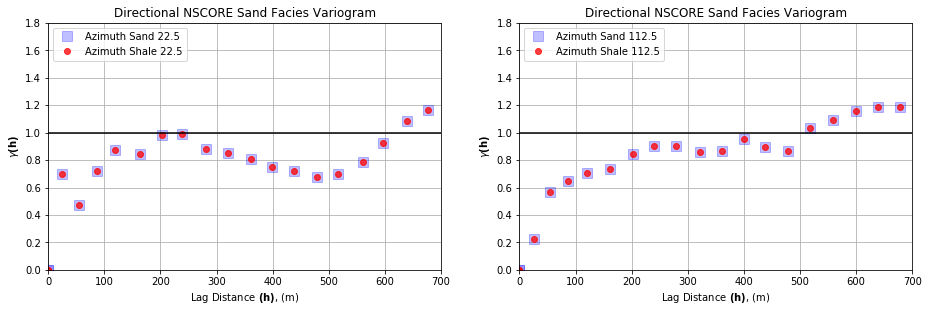

In [9]:
# directional variogram for facies
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 40.0; lag_tol = 40.0; nlag = 20;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

lag_sand = np.zeros((len(azi_mat),nlag+2)); gamma_sand = np.zeros((len(azi_mat),nlag+2)); npp_sand = np.zeros((len(azi_mat),nlag+2));
lag_shale = np.zeros((len(azi_mat),nlag+2)); gamma_shale = np.zeros((len(azi_mat),nlag+2)); npp_shale = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_sand[iazi,:], gamma_sand[iazi,:], npp_sand[iazi,:] = geostats.gamv(df_clean,"X","Y","NSand",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    lag_shale[iazi,:], gamma_shale[iazi,:], npp_shale[iazi,:] = geostats.gamv(df_clean,"X","Y","NShale",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_sand[iazi,:],gamma_sand[iazi,:],'s',color = 'blue',alpha=0.25,markersize=10,label = 'Azimuth Sand ' +str(azi_mat[iazi]))
    plt.plot(lag_shale[iazi,:],gamma_shale[iazi,:],'o',color = 'red',alpha=0.75,label = 'Azimuth Shale ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Sand Facies Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

In [10]:
# variogram model code
import math


def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
                cov1 = pmx - cc[js] * (h ** aa[js])
                cova2_ = cova2_ + cov1
    return cova2_

def vmodel(
    nlag,
    xlag,
    azm,
    vario
):
    """GSLIB's VMODEL program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Mar, 2019).
    :param nlag: number of variogram lags 
    :param xlag: size of the lags
    :param axm: direction by 2D azimuth, 000 is y positive, 090 is x positive 
    :param vario: dictionary with the variogram parameters
    :return:
    """
    
# Parameters
    MAXNST=4
    DEG2RAD=3.14159265/180.0 
    MAXROT=MAXNST+1
    EPSLON = 1.0e-20
    VERSION= 1.01
  
# Declare arrays
    index = np.zeros(nlag+1)
    h = np.zeros(nlag+1)
    gam = np.zeros(nlag+1)
    cov = np.zeros(nlag+1)
    ro = np.zeros(nlag+1)
    
# Load the variogram
    nst = vario["nst"]
    cc = np.zeros(nst)
    aa = np.zeros(nst)
    it = np.zeros(nst)
    ang = np.zeros(nst)
    anis = np.zeros(nst)
    
    c0 = vario["nug"]
    cc[0] = vario["cc1"]
    it[0] = vario["it1"]
    ang[0] = vario["azi1"]
    aa[0] = vario["hmaj1"]
    anis[0] = vario["hmin1"] / vario["hmaj1"]
    if nst == 2:
        cc[1] = vario["cc2"]
        it[1] = vario["it2"]
        ang[1] = vario["azi2"]
        aa[1] = vario["hmaj2"]
        anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
    xoff = math.sin(DEG2RAD*azm)*xlag
    yoff = math.cos(DEG2RAD*azm)*xlag
    print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
    rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
    xx = 0.0; yy = 0.0      
    for il in range(0,nlag+1):
        index[il] = il
        cov[il] = cova2(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
        gam[il] = maxcov - cov[il]
        ro[il]  = cov[il]/maxcov
        h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
        xx = xx + xoff
        yy = yy + yoff

# finished
    return index,h,gam,cov,ro
    

The empirical variograms were modeled using a 2-nested variogram model. A small nugget effect accounting for 10% of the variance is included as well. The first structure used is a exponential structure, and the second is a Gaussian structure. The range in the minor direction is estimated to be 220m and the range in the major direction is estimated to be 500m. These ranges are consistent with our expectations visually from the facies map drawn from the well data.

 x,y,z offsets = 36.95518133479533,-15.30733721169019
 x,y,z offsets = 15.30733727802091,36.955181307320245


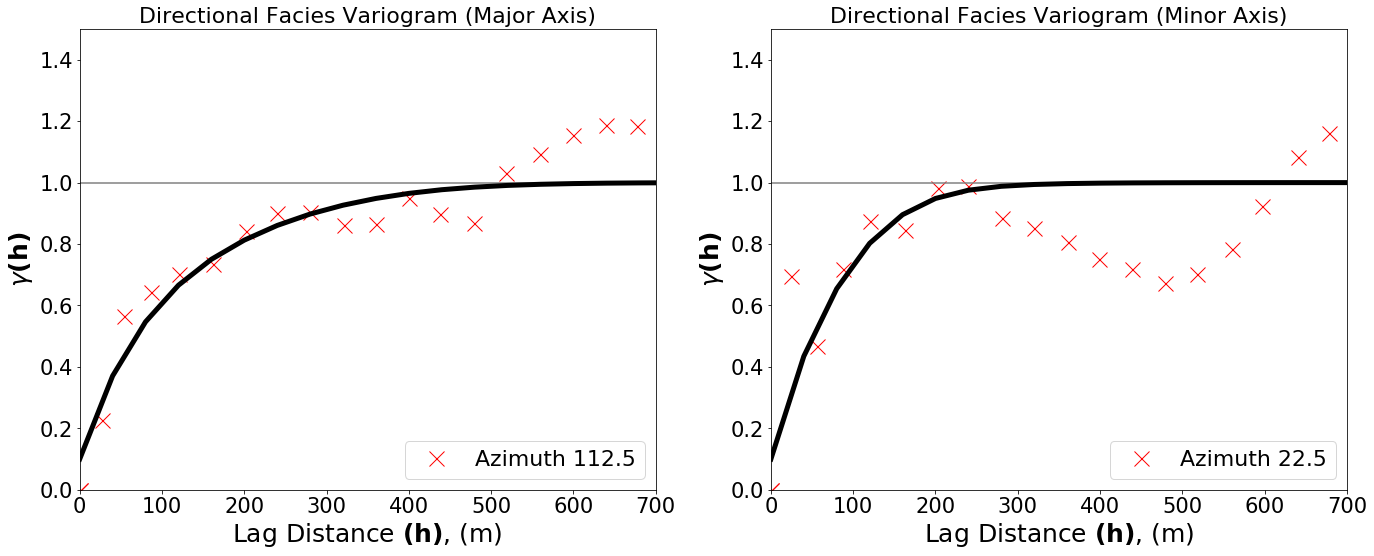

In [11]:
# fitting model variograms

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(df_clean,"X","Y","NSand",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(df_clean,"X","Y","NSand",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.1                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 2; it2 = 3            # defining types of model variograms 1=spherical, 2=exponential, 3=Gaussian
cc1 = 0.7; cc2 = 0.2       # defining contributions of each structure
azi1 = 112.5; azi2 = 112.5     # defining major azimuthal direction
hmaj1 = 250; hmaj2 = 500     # defining range in major direction
hmin1 = 200; hmin2 = 220     # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 40; xlag = 40; azm = 112.5; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 22.5
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Directional Facies Variogram (Major Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Directional Facies Variogram (Minor Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

Using the parameters from the modeled variograms, the indicator kriging can take place.

In [12]:
# basic IK parameters
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

In [13]:
# additional grid parameters
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

In [14]:
# computing global properties of the facies
prob_sand = df_clean['indicator_sand'].mean()
print("Global Proportion of Sandstone = " + str(np.round(prob_sand,2)))
print("Global Proportion of Shale = " + str(np.round(1-prob_sand,2)))

Global Proportion of Sandstone = 0.76
Global Proportion of Shale = 0.24


In [15]:
# applying the fit model variograms
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.76,0.24]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)) # sand indicator variogram

Data for IK3D: Variable column Facies
  Number   = 217
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


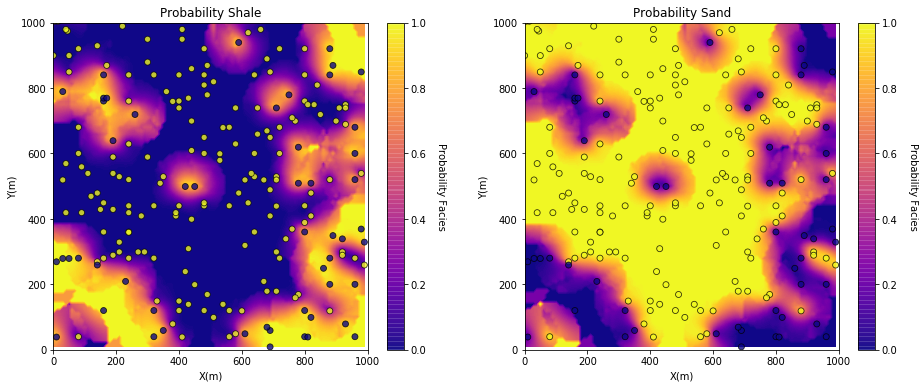

In [16]:
# do indicator kriging
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df_clean,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

cmap = plt.cm.plasma
plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df_clean,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df_clean,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Using the kriged results from the indicator kriging, the above maps visualize the probability of each facies across the reservoir.

### 2. Ordinary kriging workflow
For porosity and permeability data, computed by-facies.

Plot of the porosity and permeability data for each facies to determine if there are visible trends in the data that need to be removed. Isolation of the well data by facies removes the largest discrepancies, so there is the chance no trend removal will be required.

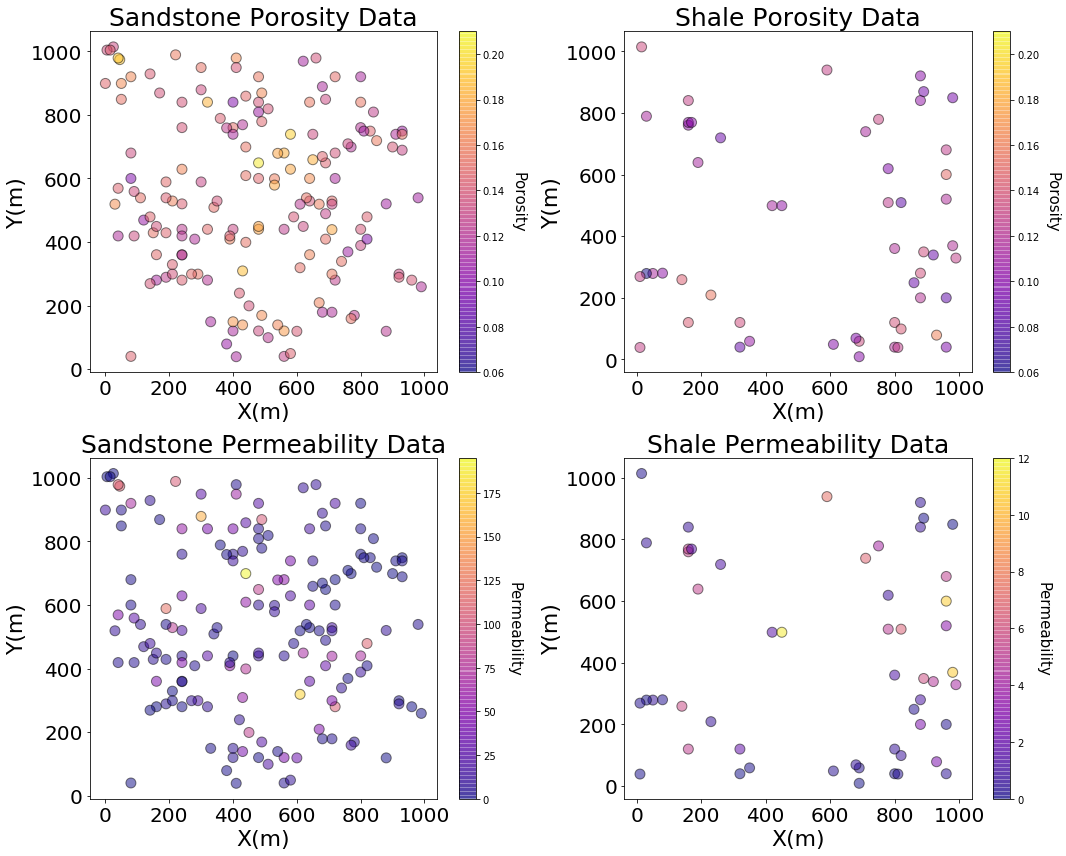

In [17]:
# plotting porosity and permeability by-facies
plt.figure(figsize=(15,12))
# porosity in sandstone
plt.subplot(221)
im = plt.scatter(Sandstone_final['X'],Sandstone_final['Y'],s=100,c=Sandstone_final['Porosity'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=0.06,
                 vmax=0.21,alpha=0.5,verts=None,edgecolors="black")
plt.title('Sandstone Porosity Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Porosity',rotation=270,labelpad=20,size=15)

# porosity in shale
plt.subplot(222)
im = plt.scatter(Shale_final['X'],Shale_final['Y'],s=100,c=Shale_final['Porosity'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=0.06,
                 vmax=0.21,alpha=0.5,verts=None,edgecolors="black")
plt.title('Shale Porosity Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Porosity',rotation=270,labelpad=20,size=15)

# permeability in sandstone
plt.subplot(223)
im = plt.scatter(Sandstone_final['X'],Sandstone_final['Y'],s=100,c=Sandstone_final['Perm'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=0.0,
                 vmax=195,alpha=0.5,verts=None,edgecolors="black")
plt.title('Sandstone Permeability Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Permeability',rotation=270,labelpad=20,size=15)

# permeability in shale
plt.subplot(224)
im = plt.scatter(Shale_final['X'],Shale_final['Y'],s=100,c=Shale_final['Perm'],
                 marker=None,cmap=plt.cm.plasma,norm=None,vmin=0.0,
                 vmax=12,alpha=0.5,verts=None,edgecolors="black")
plt.title('Shale Permeability Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Permeability',rotation=270,labelpad=20,size=15)

plt.tight_layout()
plt.show()

There do not appear to be strong visible trends in the data. In fact some of the data seems to be pretty well distributed already. To further test this, distributions of the variable of interest will be computed along the X and Y axes to check for spatial spread or trend.

### Checking for trends...

First the data will be normal score transformed and then the distributions of porosity and permeability for both sandstone and shale along both axes will be tested.

In [18]:
geostats.nscore

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

In [19]:
# normalizing the porosity distribution by facies
Sandstone_final['NPor'], tvPorSand, tnsPorSand = geostats.nscore(Sandstone_final, 'Porosity')  # nscore transform for sand facies porosity 
Shale_final['NPor'], tvPorShale, tnsPorShale = geostats.nscore(Shale_final, 'Porosity')  # nscore transform for shale facies porosity
# normalizing the permeabilities by facies
Sandstone_final['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(Sandstone_final, 'Perm')  # nscore transform for sand facies permeability
Shale_final['NPerm'], tvPermShale, tnsPermShale = geostats.nscore(Shale_final, 'Perm')  # nscore transform for shale facies permeability

/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

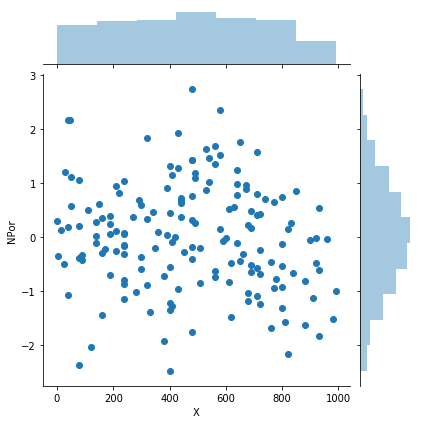

In [20]:
sns.jointplot(x='X',y='NPor',data=Sandstone_final)

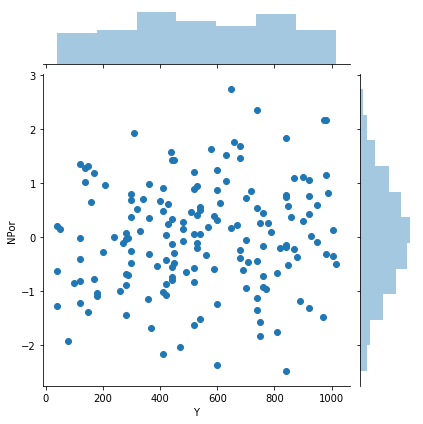

In [21]:
sns.jointplot(x='Y',y='NPor',data=Sandstone_final)

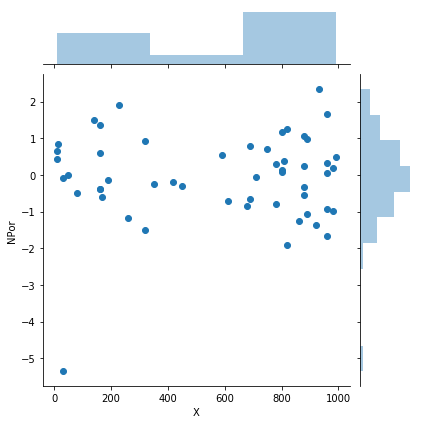

In [22]:
sns.jointplot(x='X',y='NPor',data=Shale_final)

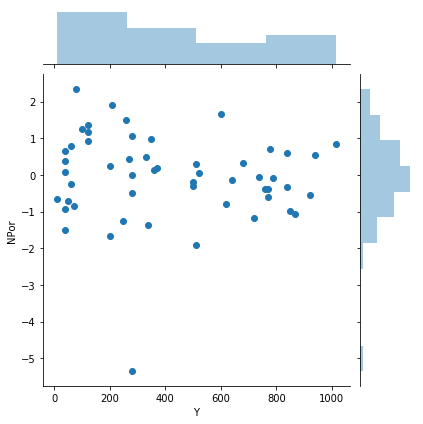

In [23]:
sns.jointplot(x='Y',y='NPor',data=Shale_final)

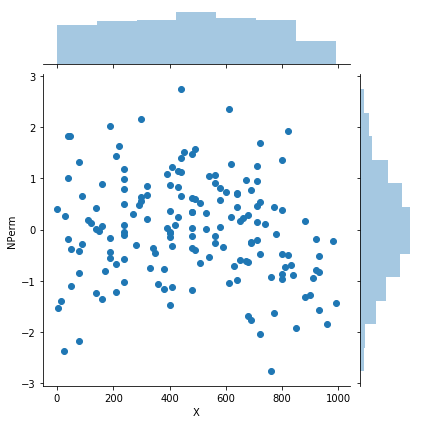

In [24]:
sns.jointplot(x='X',y='NPerm',data=Sandstone_final)

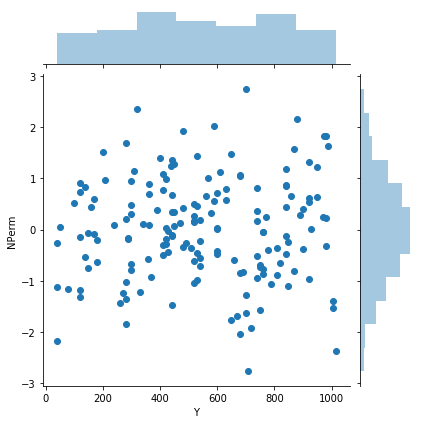

In [25]:
sns.jointplot(x='Y',y='NPerm',data=Sandstone_final)

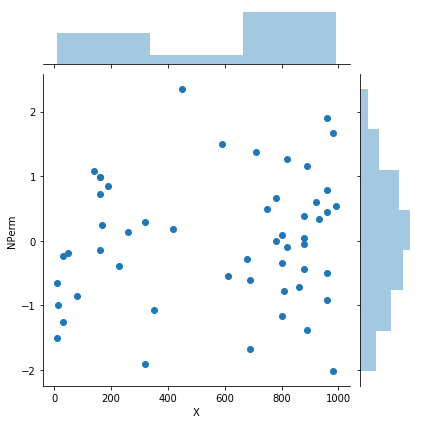

In [26]:
sns.jointplot(x='X',y='NPerm',data=Shale_final)

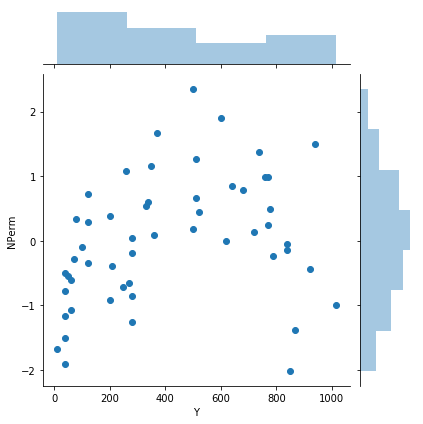

In [27]:
sns.jointplot(x='Y',y='NPerm',data=Shale_final)

The plots generated above do not seem to indicate trends in either of the principal directions (X or Y). We take this as an indication that any potential trends in off-directions are relatively weak. The absence of strong trends in the data means that the process of trend removal will be skipped, and the normal transformed data will continue to be used for the variogram modeling and then the kriging.

### Empirical variograms

The major direction is known to be 22.5 degrees and the minor direction is 112.5 degrees. We had a lot of difficulty in the previous update when developing fits to experimental variograms for this data. To help alleviate these challenges, we have oversmoothed the variograms by applying a large lag tolerance and a small distance between the lags which in effect counts data multiple times and smooths the variogram.

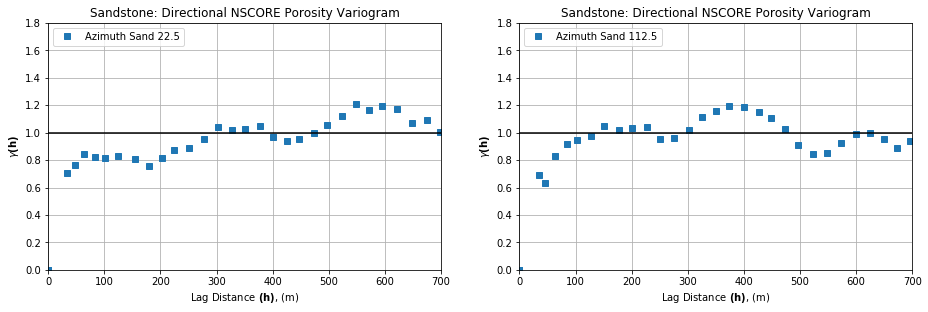

In [28]:
# directional variogram for porosity in sandstone
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
lag_sand = np.zeros((len(azi_mat),nlag+2)); gamma_sand = np.zeros((len(azi_mat),nlag+2)); npp_sand = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_sand[iazi,:], gamma_sand[iazi,:], npp_sand[iazi,:] = geostats.gamv(Sandstone_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_sand[iazi,:],gamma_sand[iazi,:],'s',label = 'Azimuth Sand ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Sandstone: Directional NSCORE Porosity Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

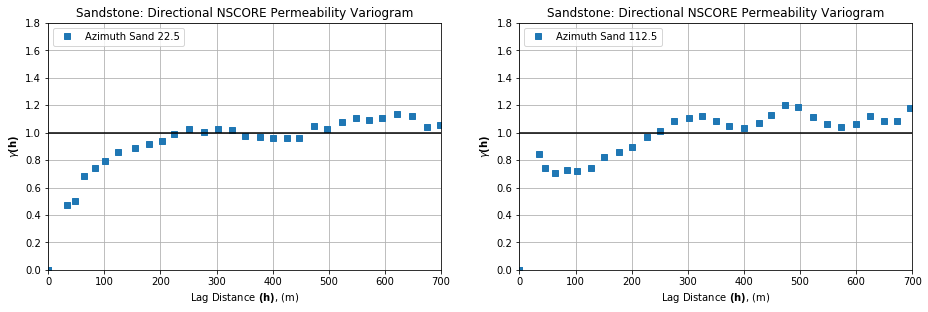

In [29]:
# directional variogram for permeability in sandstone
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
lag_sand = np.zeros((len(azi_mat),nlag+2)); gamma_sand = np.zeros((len(azi_mat),nlag+2)); npp_sand = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_sand[iazi,:], gamma_sand[iazi,:], npp_sand[iazi,:] = geostats.gamv(Sandstone_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_sand[iazi,:],gamma_sand[iazi,:],'s',label = 'Azimuth Sand ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Sandstone: Directional NSCORE Permeability Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

Despite efforts to over-smooth the variograms, the shale variograms are still quite noisy. We suspect that this is because of a lack of data coverage. After removal of outliers, there are only 53 data points for the shale facies. This makes the interpretation of the porosity variograms especially difficult, leading us to suggest that there is little to no spatial continuity in the shale porosity given the data we have. For permeability we try to fit and model some of the variance.

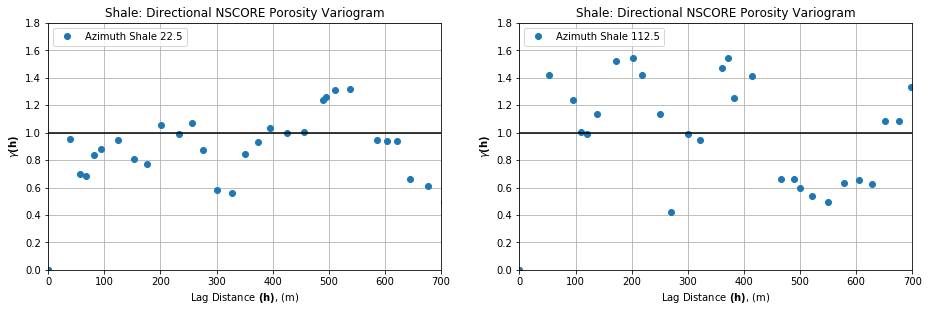

In [30]:
# directional variogram for porosity in shale
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
lag_shale = np.zeros((len(azi_mat),nlag+2)); gamma_shale = np.zeros((len(azi_mat),nlag+2)); npp_shale = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_shale[iazi,:], gamma_shale[iazi,:], npp_shale[iazi,:] = geostats.gamv(Shale_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_shale[iazi,:],gamma_shale[iazi,:],'o',label = 'Azimuth Shale ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Shale: Directional NSCORE Porosity Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

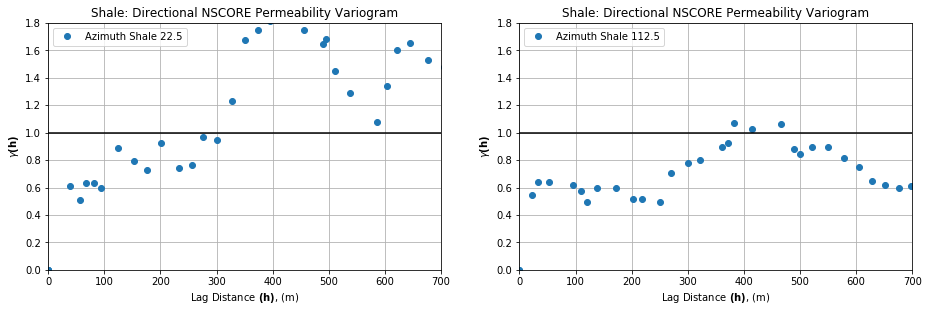

In [31]:
# directional variogram for permeability in shale
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [22.5,112.5]           # directions in azimuth to consider

lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));
lag_shale = np.zeros((len(azi_mat),nlag+2)); gamma_shale = np.zeros((len(azi_mat),nlag+2)); npp_shale = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_shale[iazi,:], gamma_shale[iazi,:], npp_shale[iazi,:] = geostats.gamv(Shale_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_shale[iazi,:],gamma_shale[iazi,:],'o',label = 'Azimuth Shale ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Shale: Directional NSCORE Permeability Variogram')
    plt.xlim([0,700])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

### Modeling the variograms...
Definitely some trouble modeling the shale variograms; likely due to the data coverage and general sparseness of the shale data available. Some cyclicity in the sandstone variograms appears to be present, could also be due to data coverage. Settings used for experimental variogram modeling had high tolerances and oversmoothed the data and also may have exposed spatial coverage artifacts rather than actual variogram results. This is one reason why the models are fit to the general trend.

 x,y,z offsets = 19.134171597526137,46.1939766341503
 x,y,z offsets = 46.19397666849416,-19.134171514612735


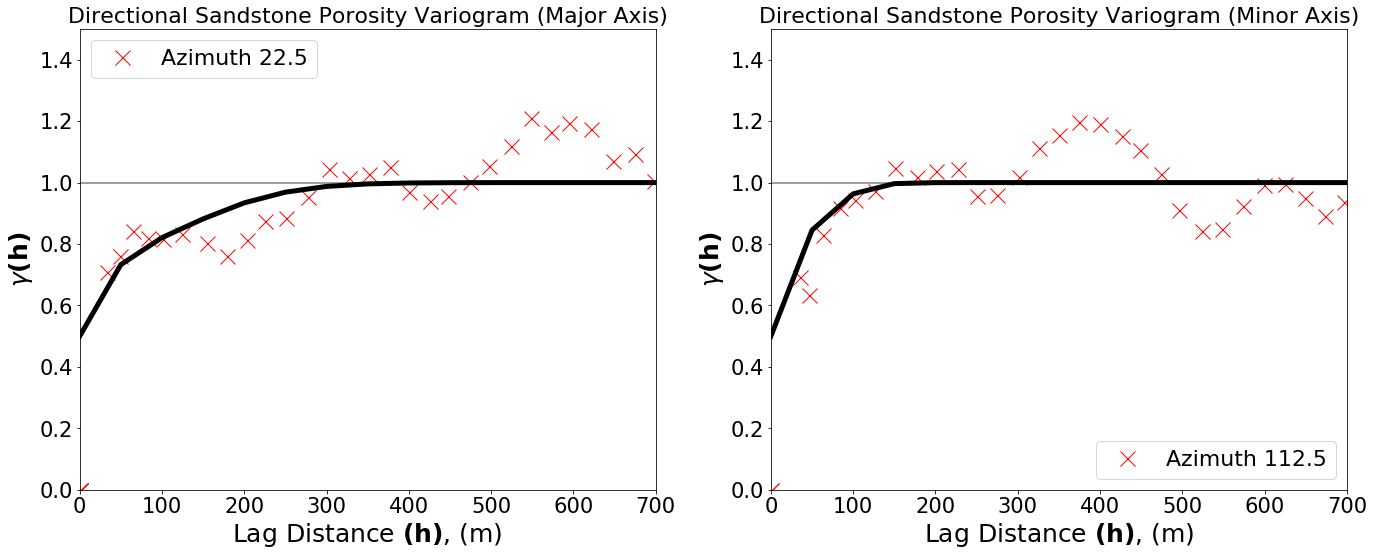

In [32]:
# model variogram - sandstone porosity
# recompute experimental variogram
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
azi_mat = [22.5, 112.5]                             # major and minor directions

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(Sandstone_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(Sandstone_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.5                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 3             # defining types of model variograms
cc1 = 0.25; cc2 = 0.25       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 75; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 125     # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 14; xlag = 50; azm = 22.5; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 112.5
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Directional Sandstone Porosity Variogram (Major Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper left',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Directional Sandstone Porosity Variogram (Minor Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 19.134171597526137,46.1939766341503
 x,y,z offsets = 46.19397666849416,-19.134171514612735


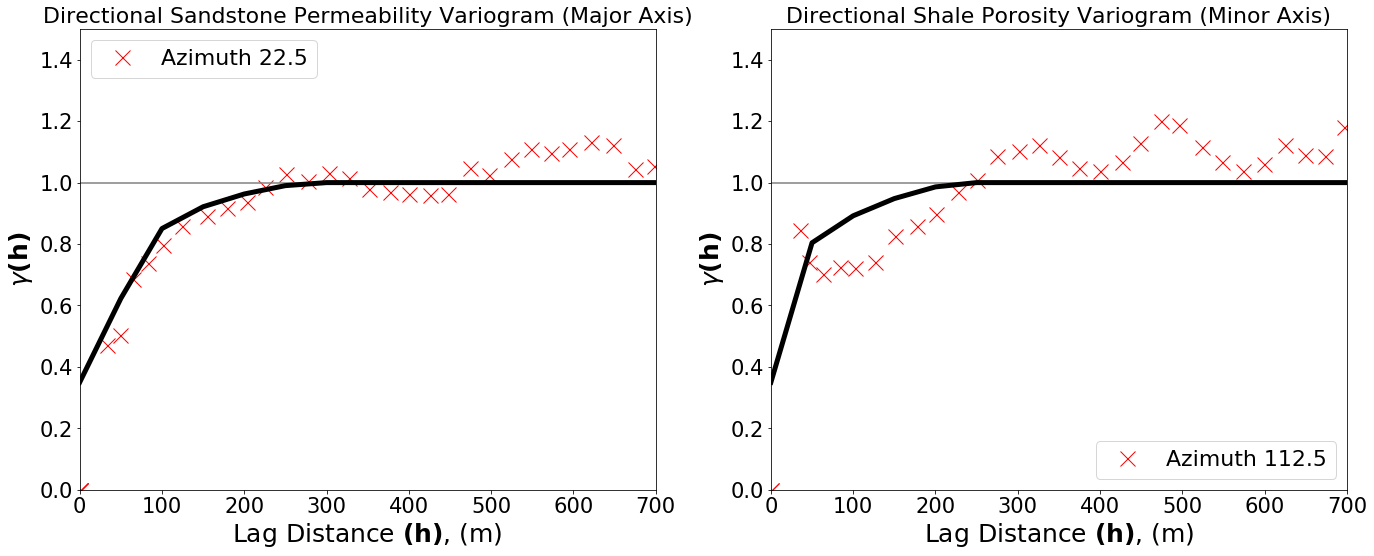

In [33]:
# model variogram - sandstone permeability
# recompute experimental variogram
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
azi_mat = [22.5, 112.5]                             # major and minor directions

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(Sandstone_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(Sandstone_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.35                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 3; it2 = 1             # defining types of model variograms
cc1 = 0.4; cc2 = 0.25       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 250     # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 14; xlag = 50; azm = 22.5; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 112.5
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Directional Sandstone Permeability Variogram (Major Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper left',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Directional Shale Porosity Variogram (Minor Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

 x,y,z offsets = 19.134171597526137,46.1939766341503
 x,y,z offsets = 46.19397666849416,-19.134171514612735


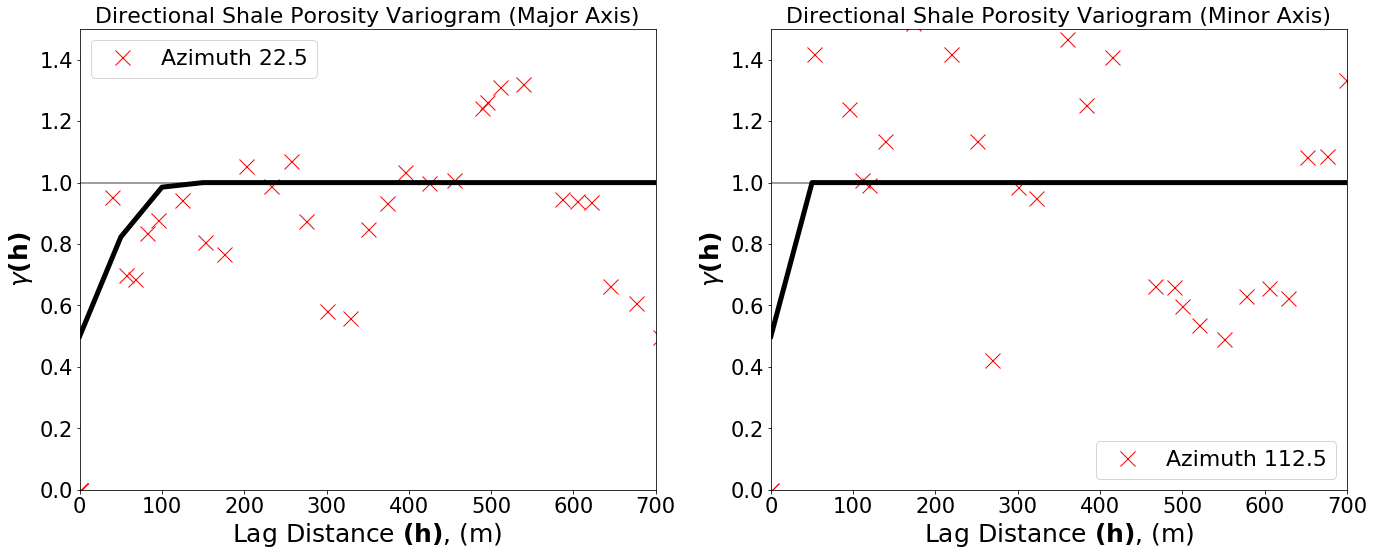

In [34]:
# model variogram - shale porosity
# recompute experimental variogram
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
azi_mat = [22.5, 112.5]                             # major and minor directions

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(Shale_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(Shale_final,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.5                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 1             # defining types of model variograms
cc1 = 0.4; cc2 = 0.1       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 150  # defining range in major direction
hmin1 = 5; hmin2 = 5     # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 14; xlag = 50; azm = 22.5; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 112.5
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Directional Shale Porosity Variogram (Major Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper left',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Directional Shale Porosity Variogram (Minor Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

 make_variogram Warning: major range should be greater than minor range 
 x,y,z offsets = 19.134171597526137,46.1939766341503
 x,y,z offsets = 46.19397666849416,-19.134171514612735


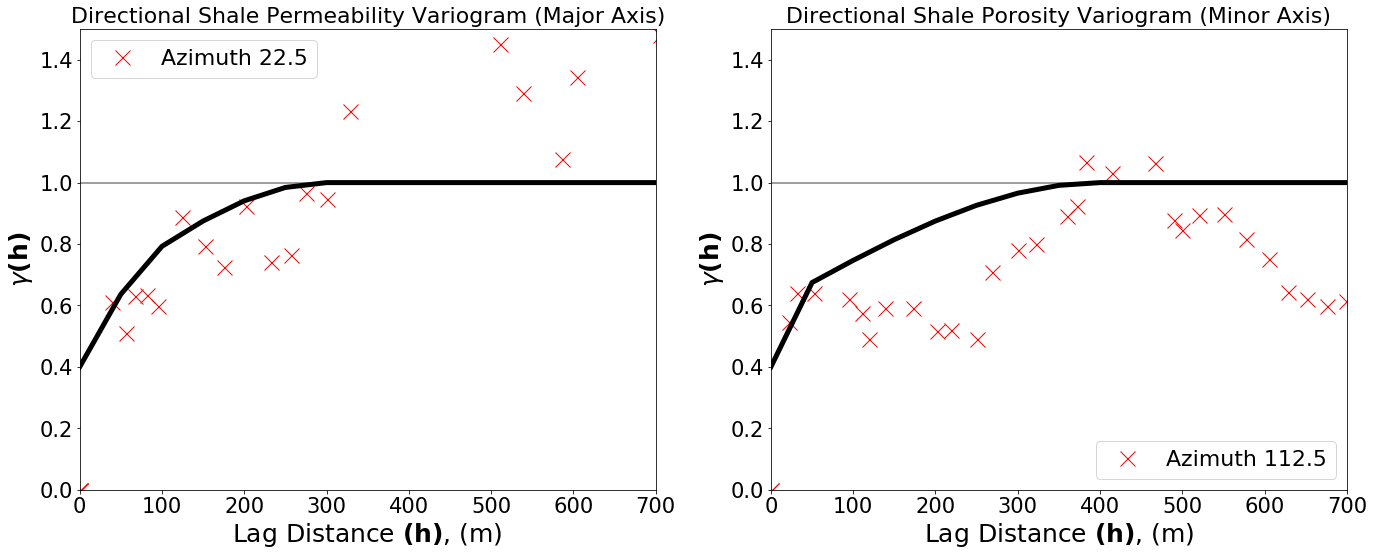

In [35]:
# model variogram - shale permeability
# recompute experimental variogram
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 25.0; lag_tol = 50.0; nlag = 50;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
azi_mat = [22.5, 112.5]                             # major and minor directions

# major direction
major_lag, major_gamma, major_npp = geostats.gamv(Shale_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[0],atol,bandh,isill)
    
# minor direction
minor_lag, minor_gamma, minor_npp = geostats.gamv(Shale_final,"X","Y","NPerm",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[1],atol,bandh,isill)

# fit porosity model variogram to experimental
nug = 0.4                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 1             # defining types of model variograms
cc1 = 0.2; cc2 = 0.4       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 400     # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 14; xlag = 50; azm = 22.5; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
azm = 112.5
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(major_lag,major_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h45,gam45,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf(h)$',fontsize=25)
plt.title('Directional Shale Permeability Variogram (Major Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper left',fontsize=22)

plt.subplot(1,2,2)
plt.plot(minor_lag,minor_gamma,'x',markersize=15,color = 'red',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,2000],[1.0,1.0],color = 'grey')
plt.plot(h135,gam135,color = 'black',linewidth=5)
plt.xlabel(r'Lag Distance $\bf(h)$, (m)',fontsize=25)
plt.ylabel(r'$\gamma \bf (h)$',fontsize=25)
plt.title('Directional Shale Porosity Variogram (Minor Axis)',fontsize=22)
plt.xlim([0,700])
plt.ylim([0,1.5])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='lower right',fontsize=22)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

### Ordinary kriging
Elected to perform ordinary kriging rather than simple kriging because ordinary kriging does not assume that regions beyond the range of the data trend towards the global mean (aka the field is stationary). 

In [36]:
# sandstone porosity OK
skmean_por = 0.14; skmean_perm = 23.0      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

nug = 0.5                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 3             # defining types of model variograms
cc1 = 0.25; cc2 = 0.25       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 75; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 125     # defining range in minor direction

por_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # porosity variogram

por_kmap, por_vmap = geostats.kb2d(Sandstone_final,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

  Estimated   10000 blocks 
      average   0.1392976753521599  variance  0.000193686412129572


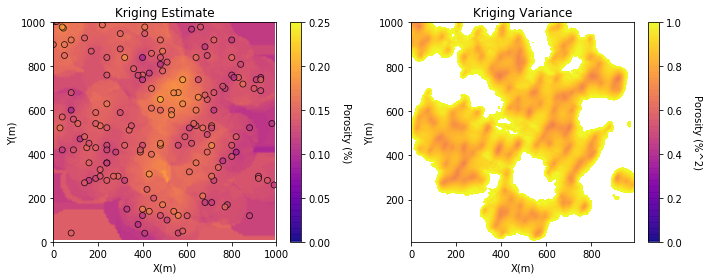

In [37]:
# plot OK for sandstone porosity
plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,Sandstone_final,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.tight_layout()
plt.show()

In [38]:
# sandstone permeability OK
skmean_por = 0.14; skmean_perm = 23.0      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

nug = 0.35                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 3; it2 = 1             # defining types of model variograms
cc1 = 0.4; cc2 = 0.25       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 250     # defining range in minor direction

perm_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # permeability variogram

perm_kmap, perm_vmap = geostats.kb2d(Sandstone_final,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,perm_vario)

  Estimated   10000 blocks 
      average   21.717518756352614  variance  625.2999619752513


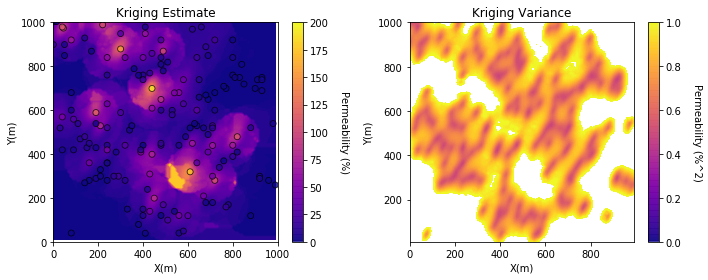

In [39]:
# plot OK for sandstone permeability
plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,200.0,Sandstone_final,'X','Y','Perm','Kriging Estimate','X(m)','Y(m)','Permeability (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Permeability (%^2)',cmap)

plt.tight_layout()
plt.show()

In [40]:
# shale porosity OK
skmean_por = 0.12; skmean_perm = 2.57      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
tmax = 9999
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

nug = 0.5                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 1             # defining types of model variograms
cc1 = 0.4; cc2 = 0.1       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 150  # defining range in major direction
hmin1 = 5; hmin2 = 5     # defining range in minor direction

por_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # porosity variogram

por_kmap, por_vmap = geostats.kb2d(Shale_final,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por,por_vario)

  Estimated   10000 blocks 
      average   0.11826177378296977  variance  0.0003047834012367429


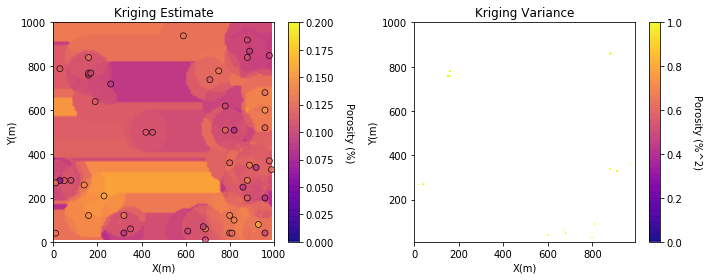

In [41]:
# plot OK for shale porosity
plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.20,Shale_final,'X','Y','Porosity','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.tight_layout()
plt.show()

In [42]:
# shale permeability OK
skmean_por = 0.12; skmean_perm = 2.57      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
tmax = 200.0
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

nug = 0.4                    # defining nugget effect
nst = 2                      # defining number of nested structures
it1 = 1; it2 = 1             # defining types of model variograms
cc1 = 0.2; cc2 = 0.4       # defining contributions of each structure
azi1 = 22.5; azi2 = 22.5     # defining major azimuthal direction
hmaj1 = 100; hmaj2 = 300  # defining range in major direction
hmin1 = 50; hmin2 = 400     # defining range in minor direction

perm_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # permeability variogram

perm_kmap, perm_vmap = geostats.kb2d(Shale_final,'X','Y','Perm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_perm,perm_vario)

 make_variogram Warning: major range should be greater than minor range 
  Estimated   10000 blocks 
      average   3.3167484059229873  variance  10.720375954980877


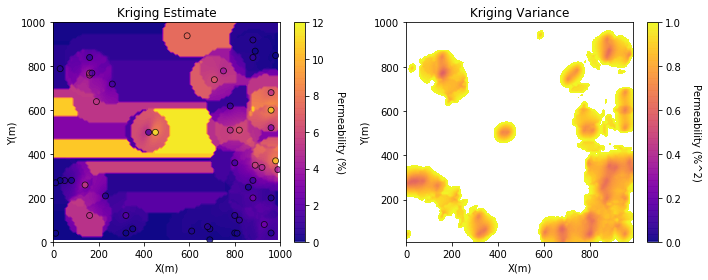

In [43]:
# plot OK for shale permeability
plt.figure(figsize=(10,4))

plt.subplot(121)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,12.0,Shale_final,'X','Y','Perm','Kriging Estimate','X(m)','Y(m)','Permeability (%)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(perm_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Permeability (%^2)',cmap)

plt.tight_layout()
plt.show()